In [137]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import scipy.interpolate
from sklearn.metrics import roc_curve, auc

# Q1

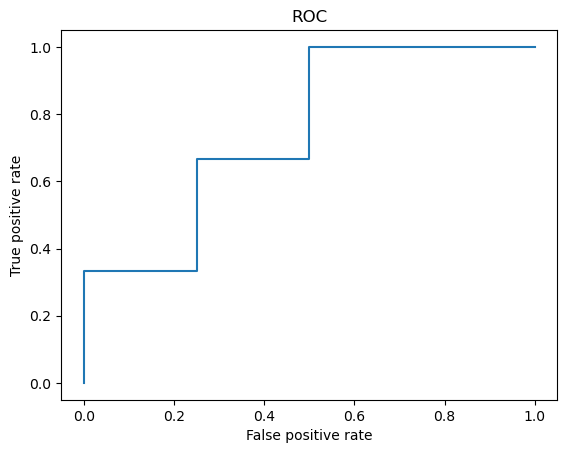

In [174]:
points = np.array([(0,0), (0, 1/3), (1/4, 1/3), (1/4, 1/2), (1/4, 2/3), (1/2, 2/3), (1/2, 5/6), (1/2, 1), (3/4,1), (1,1)])

plt.plot(points[:,0], points[:,1]) 
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.savefig('problem 1-5.png')
plt.show()

array([[0.        , 0.        ],
       [0.        , 0.33333333]])

In [2]:
# read D2 data file
def read_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        data = []
        for line in lines:
            x1, x2, y = map(float, line.strip().split())
            data.append([x1, x2, y])
        return np.array(data)

# Q2. KNN and CV

## D2z

In [157]:
# Define functions class
class KNNClassifier:
    # initilize the class with k
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def _predict(self, x):
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common
    
    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict_p(self, x):
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        prob = 1-np.bincount(k_nearest_labels)[0] / sum(np.bincount(k_nearest_labels))
        return prob
    
    def predict_p(self, X):
        y_pred = [self._predict_p(x) for x in X]
        return np.array(y_pred)

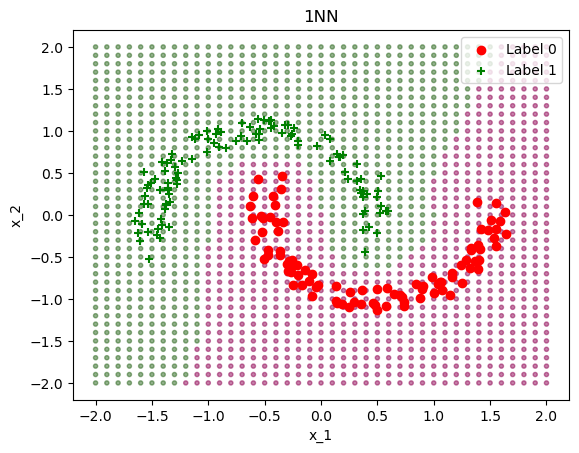

In [163]:
#  Plot
data = read_data('data/D2z.txt')
X_train = data[:, :-1]
y_train = data[:, -1]

x_plot = np.arange(-2, 2.1, 0.1)
y_plot = np.arange(-2, 2.1, 0.1)
xx, yy = np.meshgrid(x_plot, y_plot)
X_test = np.c_[xx.ravel(), yy.ravel()]

knn_1 = KNNClassifier(k = 1)
knn_1.fit(X_train, y_train)
y_pred = knn_1.predict(X_test)

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='PiYG', alpha=0.5, marker='.')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='red', label='Label 0', marker='o')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='green', label='Label 1', marker='+')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title('1NN')
plt.legend()
plt.savefig('problem 2-1.png')
plt.show()

## Implement 1NN, Run 5-fold cross validation

In [23]:
# metrics
def precision(y, y_pred):
    true_positives = np.sum((y == 1) & (y_pred == 1))
    false_positives = np.sum((y == 0) & (y_pred == 1))
    return true_positives / (true_positives + false_positives)


def recall(y, y_pred):
    true_positives = np.sum((y == 1) & (y_pred == 1))
    false_negatives = np.sum((y == 1) & (y_pred == 0))
    return true_positives / (true_positives + false_negatives)

In [38]:
df = pd.read_csv('data/emails.csv')

X = df.iloc[:, 1:-1].values 
y = df['Prediction'].values 

# folders index
fold_idx = [(np.arange(1000, 5000), np.arange(0, 1000)),
                (np.concatenate((np.arange(0, 1000), np.arange(2000, 5000))), np.arange(1000, 2000)),
                (np.concatenate((np.arange(0, 2000), np.arange(3000, 5000))), np.arange(2000, 3000)),
                (np.concatenate((np.arange(0, 3000), np.arange(4000, 5000))), np.arange(3000, 4000)),
                (np.arange(0, 4000), np.arange(4000, 5000))]

for i, (train_idx, test_idx) in enumerate(fold_idx):
    X_train, X_test, y_train, y_test= X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    knn_1 = KNNClassifier(k = 1)
    knn_1.fit(X_train, y_train)
    y_pred = knn_1.predict(X_test)

    # Metrics
    metric_acc = np.mean(y_test == y_pred)
    metric_pre = precision(y_test, y_pred)
    metric_rec = recall(y_test, y_pred)

    print(f"Fold {i + 1}:", f"Accuracy: {metric_acc}", f" Precision: {metric_pre}", f" Recall: {metric_rec}")

Fold 1: Accuracy: 0.825  Precision: 0.6536312849162011  Recall: 0.8210526315789474
Fold 2: Accuracy: 0.855  Precision: 0.6896551724137931  Recall: 0.8664259927797834
Fold 3: Accuracy: 0.863  Precision: 0.7220543806646526  Recall: 0.8415492957746479
Fold 4: Accuracy: 0.854  Precision: 0.7215568862275449  Recall: 0.8197278911564626
Fold 5: Accuracy: 0.775  Precision: 0.6051948051948052  Recall: 0.761437908496732


## Logistic

In [152]:
def sig(x):
    return 1 / (1 + np.exp(-x))

def log_reg(X, y, alpha, epsilon, max_iter):
    m, n = X.shape
    theta = np.zeros(n)
    y_hat_initial = sig(np.dot(X, theta))
    grad_initial = np.dot(X.T, (y_hat_initial - y)) / m
    grad = np.ones(n)
    iters = 0

    while max(grad) / max(grad_initial) > epsilon and iters < max_iter:
        y_hat = sig(np.dot(X, theta))
        grad = np.dot(X.T, (y_hat - y)) / m
        theta = theta - alpha * grad
        iters += 1
    return theta

def predict(X, theta):
    p = sig(np.dot(X, theta))
    return (p > 0.5).astype(int)

def predict_p(X, theta):
    p = sig(np.dot(X, theta))
    return p

In [131]:
alpha = 0.001
epsilon = 1e-8
max_iter = 1e4

for i, (train_idx, test_idx) in enumerate(fold_idx):
    X_train, X_test, y_train, y_test= X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    X_train = np.c_[np.ones(X_train.shape[0]), X_train]
    X_test = np.c_[np.ones(X_test.shape[0]), X_test]

    theta = log_reg(X_train, y_train, alpha, epsilon, max_iter)

    y_pred = predict(X_test, theta)

    # Metrics
    metric_acc = np.mean(y_test == y_pred)
    metric_pre = precision(y_test, y_pred)
    metric_rec = recall(y_test, y_pred)

    print(f"Fold {i + 1}:", f"Accuracy: {metric_acc}", f" Precision: {metric_pre}", f" Recall: {metric_rec}")

Fold 1: Accuracy: 0.949  Precision: 0.9301470588235294  Recall: 0.887719298245614
Fold 2: Accuracy: 0.947  Precision: 0.917910447761194  Recall: 0.8880866425992779
Fold 3: Accuracy: 0.932  Precision: 0.9390243902439024  Recall: 0.8133802816901409
Fold 4: Accuracy: 0.931  Precision: 0.900355871886121  Recall: 0.8605442176870748
Fold 5: Accuracy: 0.917  Precision: 0.8805460750853242  Recall: 0.8431372549019608


## Different k

In [135]:
avg_acc = []

for j in [1, 3, 5, 7, 10]:
    acc = []

    for i, (train_idx, test_idx) in enumerate(fold_idx):
        X_train, X_test, y_train, y_test= X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        
        knn = KNNClassifier(k = j)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        metric_acc = np.mean(y_test == y_pred)
        acc.append(metric_acc)

    avg_acc_iter = np.mean(acc)
    avg_acc.append(avg_acc_iter)
    print(f'k = {j}, Average accuracy = {avg_acc}')

k = 1, Average accuracy = [0.8344000000000001]
k = 3, Average accuracy = [0.8344000000000001, 0.841]
k = 5, Average accuracy = [0.8344000000000001, 0.841, 0.8418000000000001]
k = 7, Average accuracy = [0.8344000000000001, 0.841, 0.8418000000000001, 0.8452]
k = 10, Average accuracy = [0.8344000000000001, 0.841, 0.8418000000000001, 0.8452, 0.8558]


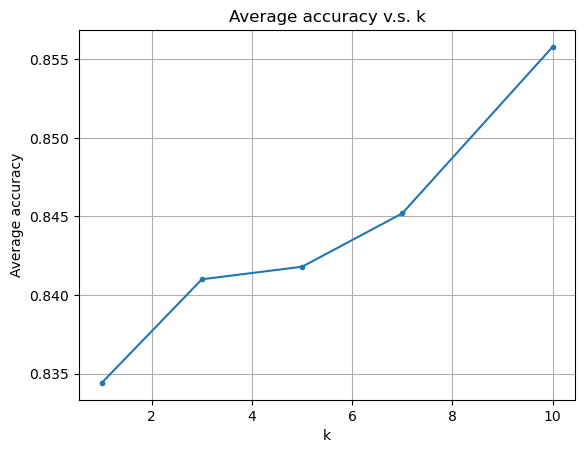

In [136]:
# Plot average accuracy versus k
plt.plot([1, 3, 5, 7, 10], avg_acc, marker='.')
plt.xlabel('k')
plt.ylabel('Average accuracy')
plt.title('Average accuracy v.s. k')
plt.grid(True)
plt.savefig('problem 2-4.png')
plt.show()

## ROC

In [177]:
train_idx = np.arange(4000)
test_idx = np.arange(4000, 5000)

X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]

knn_5 = KNNClassifier(k = 5)
knn_5.fit(X_train, y_train)
knn_pred_p = knn_5.predict_p(X_test)

alpha = 0.001
epsilon = 1e-8
max_iter = 1e4

X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

theta = log_reg(X_train, y_train, alpha, epsilon, max_iter)

log_pred_p = predict_p(X_test, theta)

fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_pred_p)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_log, tpr_log, _ = roc_curve(y_test, log_pred_p)
roc_auc_log = auc(fpr_log, tpr_log)


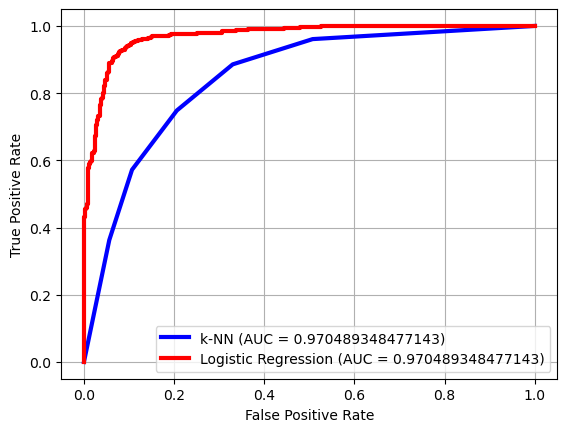

In [161]:
plt.plot(fpr_knn, tpr_knn, color='blue', lw=3, label=f'k-NN (AUC = {roc_auc_log})')
plt.plot(fpr_log, tpr_log, color='red', lw=3, label=f'Logistic Regression (AUC = {roc_auc_log})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('problem 2-5.png')
plt.show()

0.6009252125773316